In [1]:
from glob import glob
from src import Module, DataModule
import torch 
import torchmetrics 
from tqdm import tqdm
import os 
from skimage import io
import shutil
import numpy as np
import pandas as pd

In [2]:
checkpoints = glob('./checkpoints/*')
checkpoints

['./checkpoints/maxvit_da-val_f1=0.78571-epoch=2.ckpt',
 './checkpoints/maxvit_da-val_f1=0.94000-epoch=42.ckpt',
 './checkpoints/maxvit_da-epoch=49-v1.ckpt',
 './checkpoints/maxvit_da-epoch=49.ckpt',
 './checkpoints/maxvit_fc-epoch=38.ckpt',
 './checkpoints/maxvit_fc-val_f1=0.94231-epoch=37.ckpt',
 './checkpoints/maxvit_da-epoch=2.ckpt',
 './checkpoints/maxvit_da-val_f1=0.94231-epoch=20.ckpt']

In [3]:
name = "maxvit_fc-val_f1=0.94231-epoch=37.ckpt"
checkpoint = f'./checkpoints/{name}'

# module = Module.load_from_checkpoint(checkpoint)

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module = Module({"model": "maxvit_base_tf_512", "pretrained": False, "in_chans": 3})
module.load_state_dict(state_dict)


<All keys matched successfully>

In [4]:
bands = (8,2,1)

In [5]:
def eval(model, device=1, th=0.5):
	dm = DataModule(bands=bands)
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.F1Score(task="binary", threshold=th).cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = model(x.cuda(device))
			metric(y_hat, y.cuda(device).float())
			f1 = metric.compute().cpu().item()
			pbar.set_description(f'F1: {f1:.5f}')
	return f1

In [6]:
eval(module)

F1: 0.94231: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


0.942307710647583

Threshold tuning

In [7]:
thresholds = np.linspace(0.25, 0.75, 10)
data = []
for th in thresholds:
	print(f"Threshold: {th}")
	dice = eval(module, th=th)
	data.append((th, dice))

Threshold: 0.25


  0%|          | 0/32 [00:00<?, ?it/s]

F1: 0.94231: 100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


Threshold: 0.3055555555555556


F1: 0.94231: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]


Threshold: 0.3611111111111111


F1: 0.94231: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s]


Threshold: 0.41666666666666663


F1: 0.94231: 100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


Threshold: 0.4722222222222222


F1: 0.94231: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Threshold: 0.5277777777777778


F1: 0.94231: 100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Threshold: 0.5833333333333333


F1: 0.93204: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Threshold: 0.6388888888888888


F1: 0.92157: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


Threshold: 0.6944444444444444


F1: 0.93069: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


Threshold: 0.75


F1: 0.93069: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


<Axes: xlabel='Threshold'>

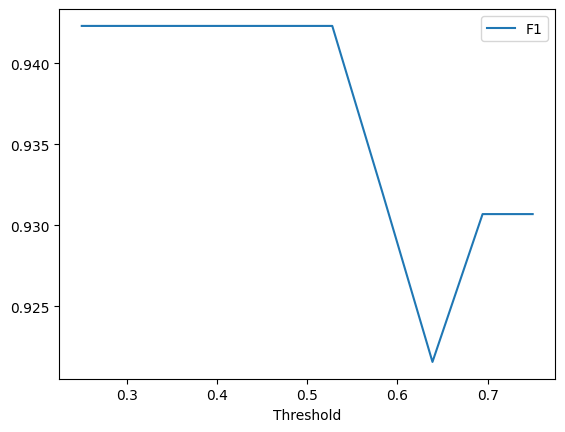

In [8]:
df = pd.DataFrame(data, columns=["Threshold", "F1"])
df.plot(x="Threshold", y="F1")

In [9]:
# get threhsold with best dice

best_th = df[df.F1 == df.F1.max()].Threshold.values[0]
best_th

0.25

In [10]:
def generate_predictions(model, device=1, th=0.5):
	dm = DataModule(bands=bands)
	dm.setup()
	test_dl = dm.test_dataloader()
	model.eval()
	model.cuda(device)
	data = []
	with torch.no_grad():
		for batch in tqdm(test_dl):
			x, image_names = batch
			y_hat = model(x.cuda(device))
			y_hat = torch.sigmoid(y_hat) > th
			y_hat = y_hat.long().cpu().numpy()
			for i, image_name in enumerate(image_names):
				data.append((image_name, y_hat[i]))
	return pd.DataFrame(data, columns=["image_name", "label"])

In [11]:
# df = generate_predictions(module, th=best_th)
df = generate_predictions(module, th=0.5)

  0%|          | 0/156 [00:00<?, ?it/s]

100%|██████████| 156/156 [02:16<00:00,  1.15it/s]


In [12]:
df['id'] = df.image_name.apply(lambda x: int(x.split(".")[0].split("_")[1]))
df = df.sort_values("id")
df = df.drop(columns="id")
df

,image_name,label
385,evaluation_0.tif,0
1041,evaluation_1.tif,0
1135,evaluation_2.tif,0
288,evaluation_3.tif,0
712,evaluation_4.tif,1
...,...,...
130,evaluation_1238.tif,0
570,evaluation_1239.tif,0
596,evaluation_1240.tif,0
144,evaluation_1241.tif,0


In [13]:
df.to_csv("submission.csv", index=False, header=False)

In [14]:
df.label.value_counts()

0    995
1    248
Name: label, dtype: int64